First we must load the processed data that was formatted into structured data
by scraping the mailing list archives and Discourse.

In [32]:
import json

# I just mapped each topic's country manually
topic_country_map = {
    9005: "DE",
    9018: "TW",
    8214: "DE",
    7876: "US",
    96843: None,
    8798: "SE",
    99509: "DK",
    8779: "ES",
    95130: "SE",
    97957: None,
    98617: "RU",
    8707: "SE",
    6884: "BE",
    7945: "SE",
    99309: None,
    91712: "RS",
    99372: "BE",
    97410: "SE",
    98461: "US",
    8357: "BR",
    98356: "DE",
    9005: "DE",
    98023: "MX",
    9020: None,
    97455: None,
    9376: "EE",
    9285: "IT"
}

with open("discourse.json", "r") as f:
    data = json.load(f)

from datetime import datetime

for comment in data:
    comment["country"] = topic_country_map[comment["topic_id"]]

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

discourse_df = pd.DataFrame(data)

def parse_rfc3339(datetime_str: str) -> datetime:
    try:
        return datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%S.%f%z")
    except ValueError:
        # Perhaps the datetime has a whole number of seconds with no decimal
        # point. In that case, this will work:
        return datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%S%z")
    
with open('mailing_archive.csv', 'r') as f:
    # use email address as username
    mailing_df = pd.read_csv(f, delimiter='|').rename(columns={"email": "username"})

mailing_df['date'] = mailing_df.apply(lambda x: parse_rfc3339(x["date"]), axis=1)
discourse_df['date'] = discourse_df.apply(lambda x: parse_rfc3339(x["date"]), axis=1)

with open("country_names.json", "r") as f:
    country_names = json.load(f)

# the query finds replies to posts that are older than the filter date, so we need to filter those out ourselves
discourse_df = discourse_df[discourse_df['date'] > parse_rfc3339("2023-01-01T00:00:00Z")]

# rename ISO codes to full country names
mailing_df['country'] = mailing_df.apply(lambda x: country_names[x['country']], axis=1)
discourse_df['country'] = discourse_df.apply(lambda x: country_names.get(x['country'], "N/A"), axis=1)

We set the colors used in our graphs here.

In [34]:
MAILING_COLOR = '#440154'
DISCOURSE_COLOR = '#edbd4c'

The first graph is a histogram of comments for both Discourse posts/replies tagged with `import` and the Imports mailing list.
For this purpose, I consider all of these to be a "comment":

* starting a thread in the Imports mailing list
* responding to a thread in the Imports mailing list
* starting a new post on Discourse with the `import` tag
* replying to a post tagged with `import`

These are fairly comparable despite the different terminology on the two platforms.

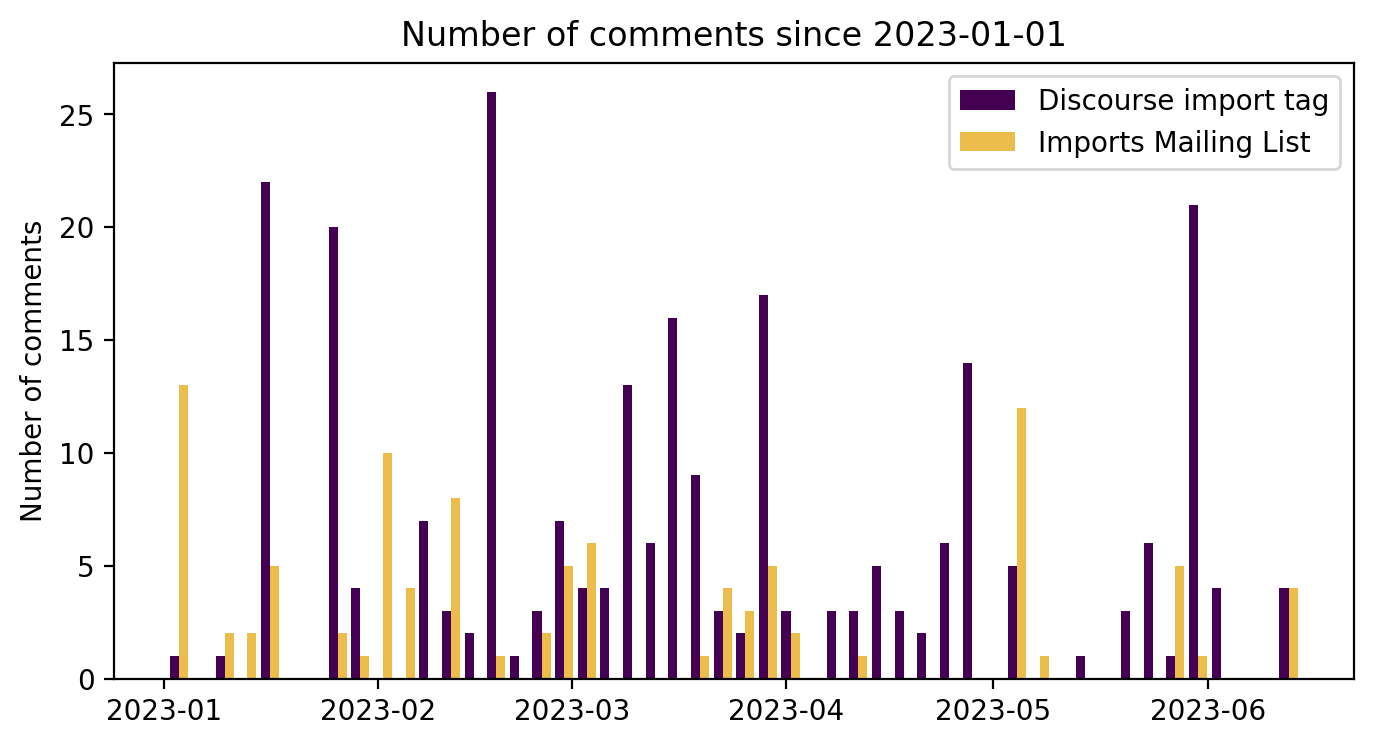

In [35]:
plt.figure(figsize=(8,4), dpi=200)
plt.hist([discourse_df['date'], mailing_df['date']], bins=50, color=[MAILING_COLOR, DISCOURSE_COLOR], label=["Discourse import tag", "Imports Mailing List"])
plt.legend()
plt.title("Number of comments since 2023-01-01")
plt.ylabel("Number of comments")
plt.show()

Next, I wanted to see the number of each users participating in each channel since the beginning of the year.

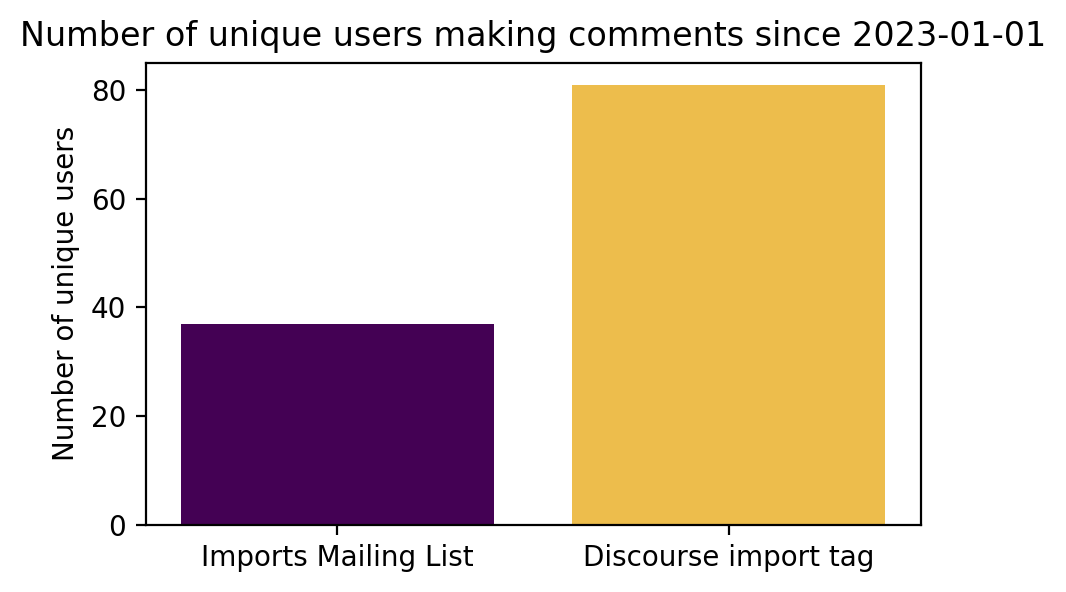

In [36]:
plt.figure(figsize=(5,3), dpi=200)
plt.title("Number of unique participating users since 2023-01-01")
plt.bar("Imports Mailing List", mailing_df['username'].nunique(), color=MAILING_COLOR)
plt.bar("Discourse import tag", discourse_df['username'].nunique(), color=DISCOURSE_COLOR)
plt.ylabel("Number of unique users")
plt.show()

I also wanted to see the unique number of comments in each channel.

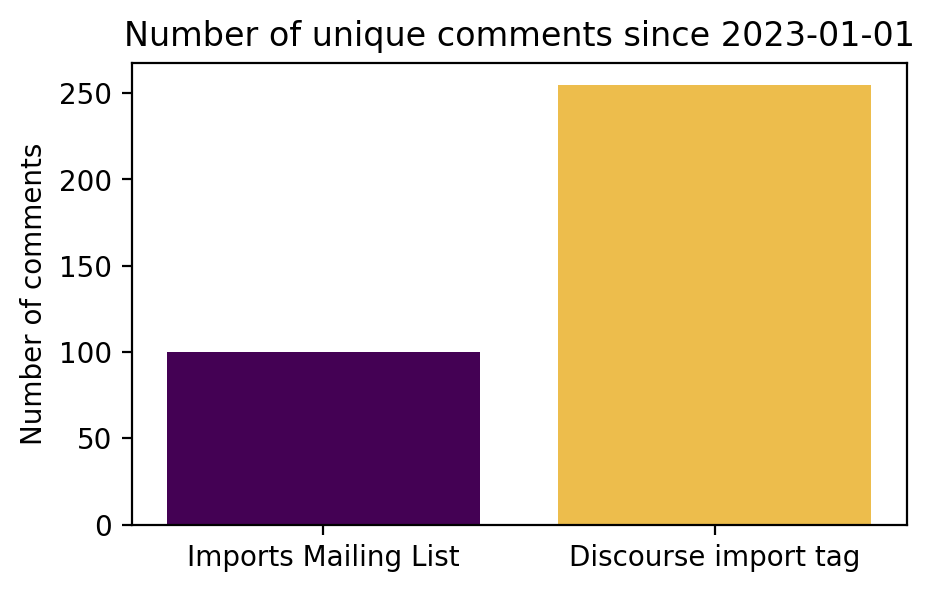

In [37]:
plt.figure(figsize=(5,3), dpi=200)
plt.title("Number of unique comments since 2023-01-01")
plt.bar("Imports Mailing List", mailing_df['username'].size, color=MAILING_COLOR)
plt.bar("Discourse import tag", discourse_df['username'].size, color=DISCOURSE_COLOR)
plt.ylabel("Number of comments")
plt.show()

Finally, I wanted to break down this analysis more by country. To do this, I manually went through and tagged
each topic by the country of import being discussed. In some cases there was no country, e.g. general import discussion.

Interestingly, the countries which participate in each channel do not overlap as much as I'd expect.
One reason may be that the Import mailing list is English-only, whereas users can communicate
in their native languages on Discourse.

This shows the number of comments broken down by country.

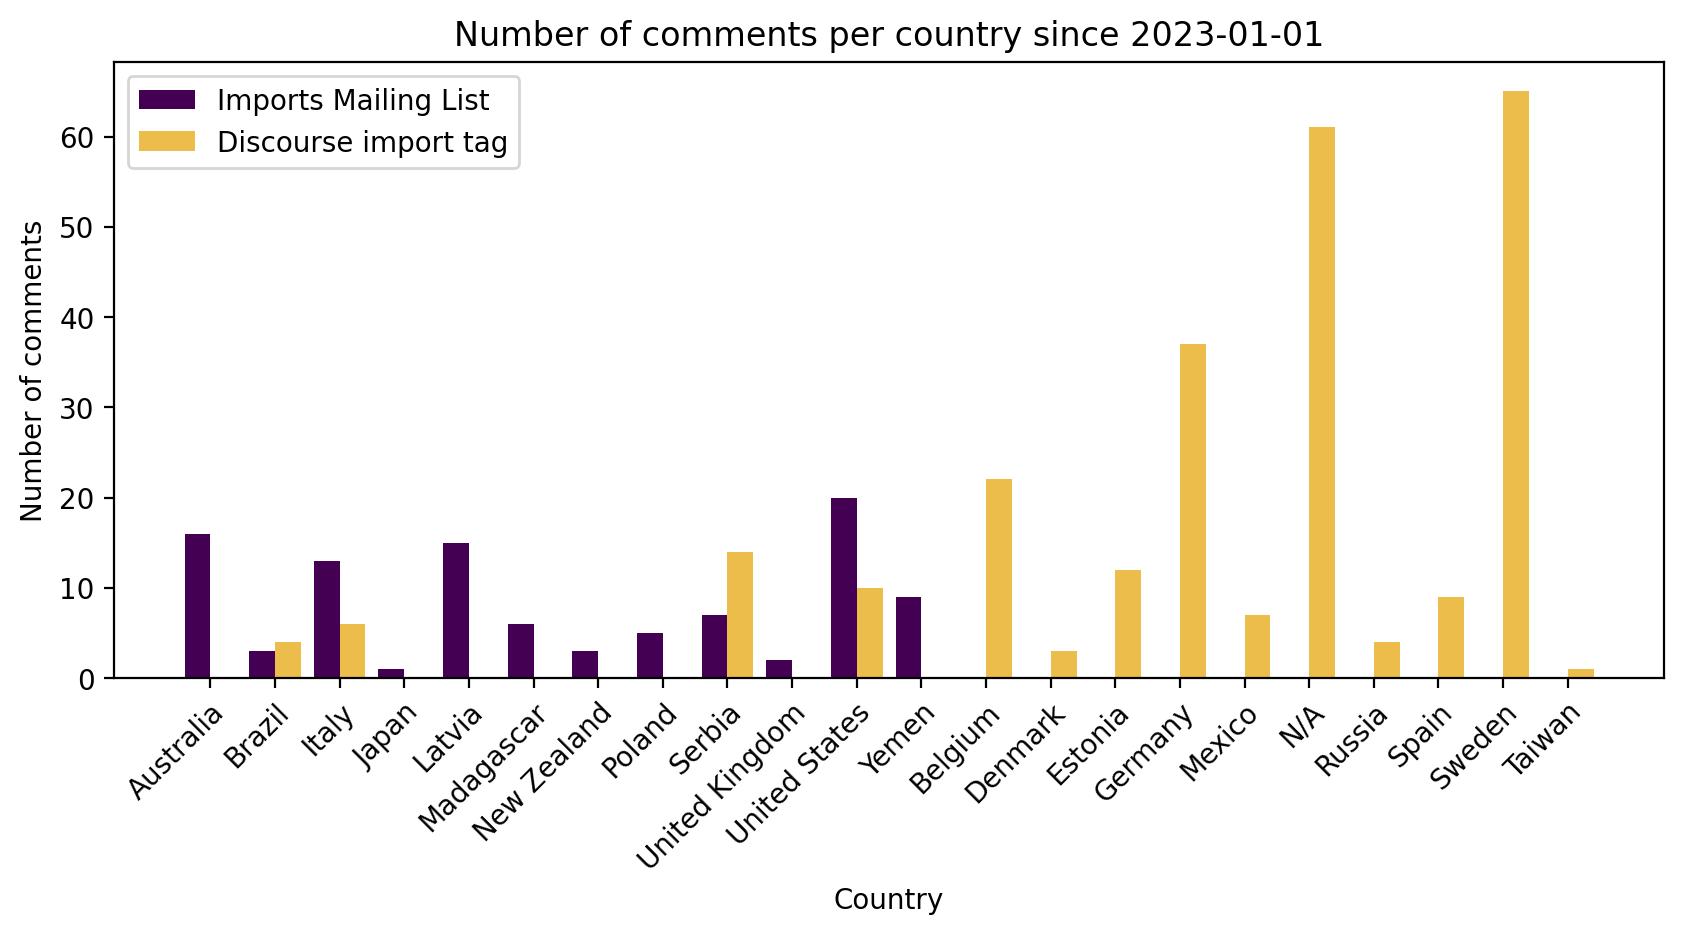

In [38]:
mailing_msg_per_country = mailing_df.groupby('country')['username'].count()
discourse_msg_per_country = discourse_df.groupby('country')['username'].count()

width = 0.4

plt.figure(figsize=(10,4), dpi=200)
plt.bar(mailing_msg_per_country.keys(), mailing_msg_per_country.values, -width, color=MAILING_COLOR, align='edge', label="Imports Mailing List")
plt.bar(discourse_msg_per_country.keys(), discourse_msg_per_country.values, width, color=DISCOURSE_COLOR, align='edge', label="Discourse import tag")
plt.legend()

plt.title("Number of comments per country since 2023-01-01")
plt.ylabel('Number of comments')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel('Country')
plt.show()

I was also curious about the number of unique users participating in threads for each country.

In this data, a user can belond to multiple countries' discussions, so they may be counted more than once.

Many of the mailing list users participate in many countries' discussions.

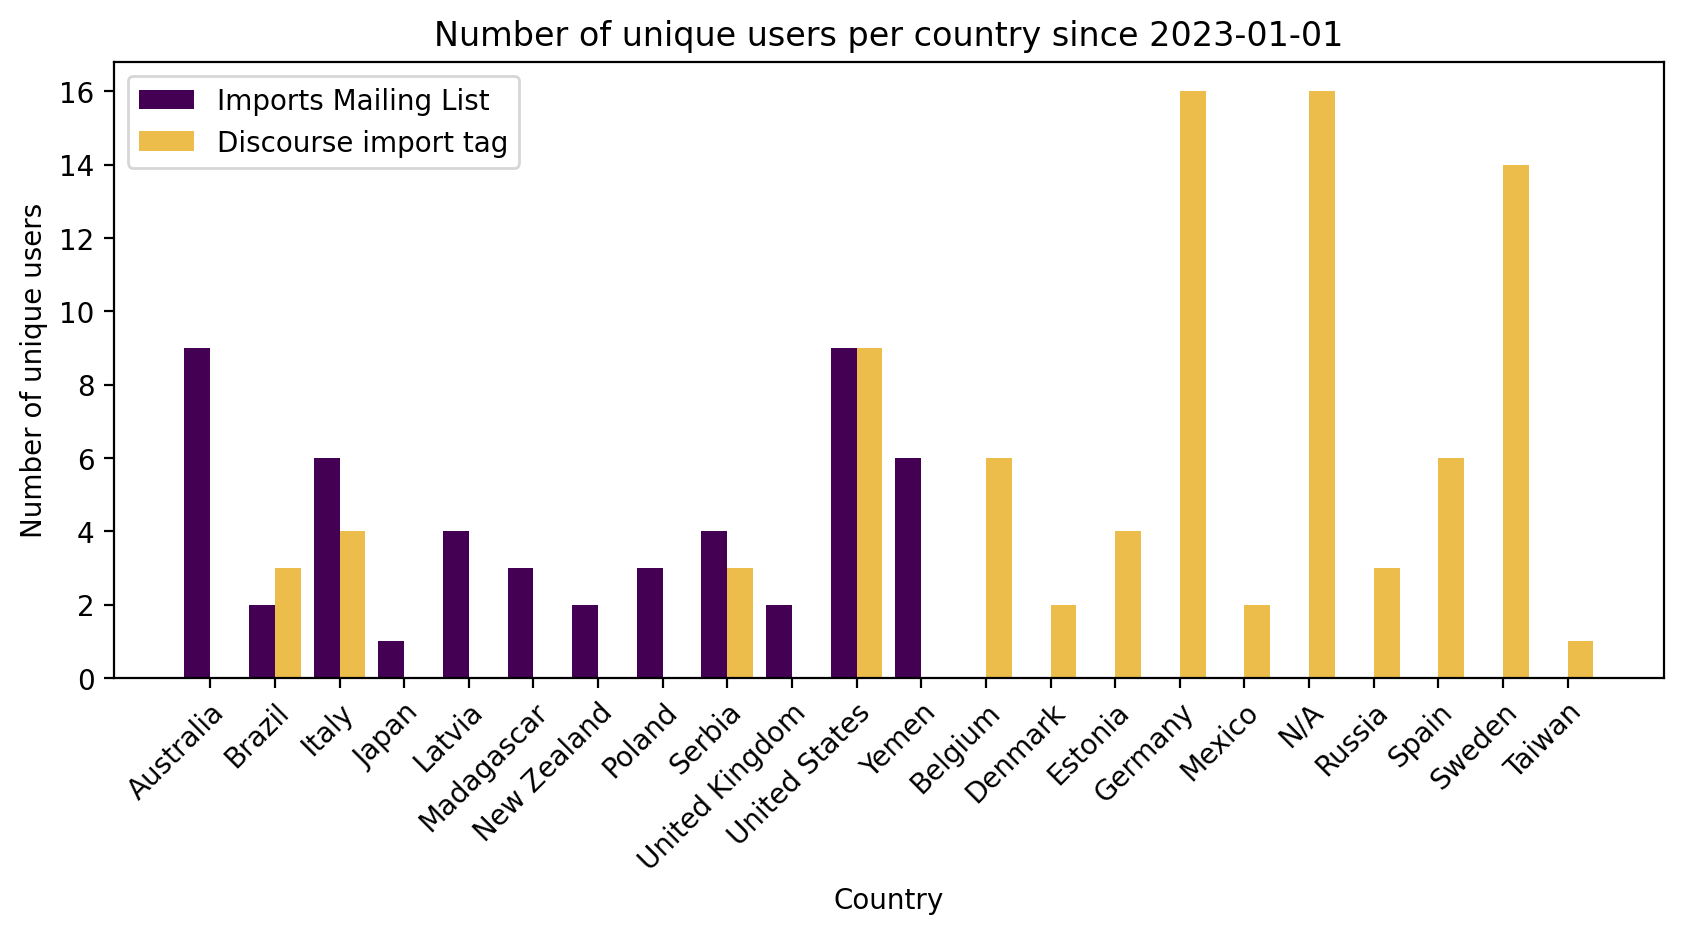

In [39]:
mailing_users_per_country = mailing_df.groupby('country')['username'].nunique()
discourse_users_per_country = discourse_df.groupby('country')['username'].nunique()

plt.figure(figsize=(10,4), dpi=200)
plt.bar(mailing_users_per_country.keys(), mailing_users_per_country.values, -width, color=MAILING_COLOR, align='edge', label="Imports Mailing List")
plt.bar(discourse_users_per_country.keys(), discourse_users_per_country.values, width, color=DISCOURSE_COLOR, align='edge', label="Discourse import tag")
plt.legend()

plt.title("Number of unique users per country since 2023-01-01")
plt.ylabel('Number of unique users')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel('Country')
plt.show()